In [1]:
import numpy as np, matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import ICRS
from astropy.time import Time
import sys
import yaml
from astroplan import Observer
import astroplan
from astroplan import Constraint, is_observable, min_best_rescale, max_best_rescale
from astroplan.constraints import _get_altaz
from astroplan import FixedTarget
from astroplan import ObservingBlock
from astroplan.constraints import TimeConstraint, AirmassConstraint
from astroplan.scheduling import Transitioner
from astroplan.scheduling import SequentialScheduler, PriorityScheduler
from astroplan.scheduling import Schedule
from sched_funcs import *
from astroplan.plots import plot_schedule_airmass

In [2]:
# define a few things
srcs = read_srcs('catalog.yaml')
loc = EarthLocation(lon=-118.2951*u.deg, lat=37.2317*u.deg, height=1222*u.m)
ovro = Observer(location=loc, name="ovro")
start_time = Time('2021-05-01 19:45')
end_time = Time('2021-05-04 01:00')
sched_starttime = '2021-05-01 19:45'

global_constraints = [
    AirmassConstraint(max=5.0),
    AzimuthConstraint(max=40.*u.deg, boolean_constraint=False),
    TimeConstraint(start_time, end_time)
]


# set up targets
targets = []
priorities = []
dm_snr = []
blocklen = []
for src in srcs['sources']:
    priorities.append(src['priority'])
    targets.append(FixedTarget(coord=SkyCoord(ra=src['RA'], dec=src['DEC'], unit=(u.hourangle, u.deg)), name=src['name']))
    dm_snr.append({'dm':src['dm'],'snr':src['snr']})
    blocklen.append(src['blocklen']*60.*u.second)
    
print(targets)

[<FixedTarget "3C48" at SkyCoord (ICRS): (ra, dec) in deg (24.42208333, 33.15975)>, <FixedTarget "3C147" at SkyCoord (ICRS): (ra, dec) in deg (85.65058333, 49.852)>, <FixedTarget "3C196" at SkyCoord (ICRS): (ra, dec) in deg (123.40025, 48.21738889)>, <FixedTarget "3C286" at SkyCoord (ICRS): (ra, dec) in deg (202.78454167, 30.50916667)>, <FixedTarget "B0329+54" at SkyCoord (ICRS): (ra, dec) in deg (53.2475, 54.57869444)>, <FixedTarget "B0950+08" at SkyCoord (ICRS): (ra, dec) in deg (148.28879167, 7.92658333)>, <FixedTarget "B1933+16" at SkyCoord (ICRS): (ra, dec) in deg (293.94929167, 16.27611111)>, <FixedTarget "B2020+28" at SkyCoord (ICRS): (ra, dec) in deg (305.65445833, 28.90641667)>, <FixedTarget "B2016+28" at SkyCoord (ICRS): (ra, dec) in deg (304.51595833, 28.66505556)>]


/home/user/dsa-notebooks/scheduler/sched_funcs.py:174: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  srcs = yaml.load(stream)


In [3]:
# blocks, transitioners

blocks = []
for i in np.arange(len(targets)):
    
    b = ObservingBlock.from_exposures(targets[i], priorities[i], blocklen[i], 1, 0, configuration = dm_snr[i]) # can add configuration dict
    blocks.append(b)
blocks.append(blocks[0])
    
slew_rate = 0.3*u.deg/u.second
transitioner = Transitioner(slew_rate)

psched = PriorityScheduler(constraints = global_constraints, observer = ovro,transitioner = transitioner)
priority_schedule = Schedule(start_time, end_time)
psched(blocks, priority_schedule)

Schedule containing 10 observing blocks between 2021-05-01 19:45:00.000 and 2021-05-04 01:00:00.000

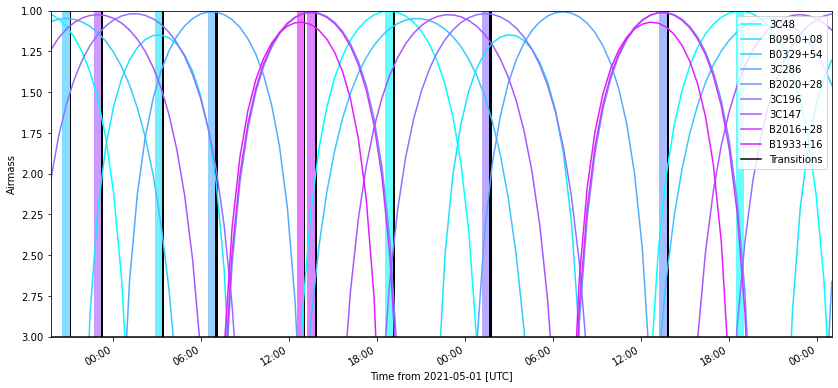

In [4]:
# plot schedule
plt.figure(figsize = (14,6))
plot_schedule_airmass(priority_schedule)
plt.legend(loc = "upper right")
plt.show()


In [5]:
t = to_table(priority_schedule,show_transitions=False)
t

target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
str8,str23,str23,float64,object,object,object
B0329+54,2021-05-01 20:33:00.002,2021-05-01 21:03:00.002,30.000000000000053,53d14m51s,54d34m43.3s,"{'dm': 26.76, 'snr': 9.0}"
3C147,2021-05-01 22:42:20.006,2021-05-01 23:12:20.006,30.000000000000053,85d39m02.1s,49d51m07.2s,"{'dm': None, 'snr': None}"
B0950+08,2021-05-02 02:51:40.016,2021-05-02 03:21:40.016,30.000000000000053,148d17m19.65s,7d55m35.7s,"{'dm': 2.97, 'snr': 9.0}"
3C286,2021-05-02 06:29:00.024,2021-05-02 06:59:00.024,29.999999999999893,202d47m04.35s,30d30m33s,"{'dm': None, 'snr': None}"
B1933+16,2021-05-02 12:32:20.037,2021-05-02 13:02:20.037,29.999999999999893,293d56m57.45s,16d16m34s,"{'dm': 158.52, 'snr': 6.5}"
B2016+28,2021-05-02 13:14:40.038,2021-05-02 13:44:40.038,29.999999999999893,304d30m57.45s,28d39m54.2s,"{'dm': 14.2, 'snr': 8.0}"
3C48,2021-05-02 18:33:40.050,2021-05-02 19:03:40.050,30.000000000000053,24d25m19.5s,33d09m35.1s,"{'dm': None, 'snr': None}"
3C196,2021-05-03 01:08:40.065,2021-05-03 01:38:40.065,30.000000000000053,123d24m00.9s,48d13m02.6s,"{'dm': None, 'snr': None}"
B2020+28,2021-05-03 13:15:00.091,2021-05-03 13:45:00.091,29.999999999999893,305d39m16.05s,28d54m23.1s,"{'dm': 24.63, 'snr': 8.0}"


In [6]:
a = define_actions(t,sched_starttime)
for aa in a:
    print(aa)

{'time': datetime.datetime(2021, 5, 1, 19, 45), 'cmd': 'move', 'val': 107.34869444444445, 'config': {'dm': 26.76, 'snr': 9.0}}
{'time': datetime.datetime(2021, 5, 1, 19, 49, 50), 'cmd': 'move', 'val': 107.34869444444445, 'config': {'dm': 26.76, 'snr': 9.0}}
{'time': datetime.datetime(2021, 5, 1, 19, 50), 'cmd': 'start', 'val': 0}
{'time': datetime.datetime(2021, 5, 1, 21, 0, 10, 2000), 'cmd': 'stop', 'val': 0}
{'time': datetime.datetime(2021, 5, 1, 21, 3, 0, 2000), 'cmd': 'move', 'val': 102.62200000000001, 'config': {'dm': None, 'snr': None}}
{'time': datetime.datetime(2021, 5, 1, 21, 7, 50, 2000), 'cmd': 'move', 'val': 102.62200000000001, 'config': {'dm': None, 'snr': None}}
{'time': datetime.datetime(2021, 5, 1, 21, 8, 0, 2000), 'cmd': 'start', 'val': 0}
{'time': datetime.datetime(2021, 5, 1, 22, 9, 0, 2000), 'cmd': 'stop', 'val': 0}
{'time': datetime.datetime(2021, 5, 1, 22, 12, 0, 2000), 'cmd': 'start', 'val': 0}
{'time': datetime.datetime(2021, 5, 1, 23, 9, 30, 6000), 'cmd': 'stop

In [7]:
np.save('actions.npy',a)